# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import json
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, concatenate, Input
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


# Functions

In [4]:
def get_images(df):
    images = []
    
    for idx, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)

        # Pre-Processing:
        #  - (Re)scaling
        #  - Standardization
        #  - Stretching
        #  - ...
        band_1 /= 255
        band_2 /= 255
        

        bands = np.dstack((band_1, band_2))
        images.append(bands)
        
    return np.array(images)


def get_angles(df):
    angles = []
    max_angle = df['inc_angle'].max()
    
    for idx, row in df.iterrows():
        angle = np.array(row['inc_angle'])
        
        # Pre-Processing:
        #  - ...
        
        #angle /= max_angle
        
        angles.append(angle)
        
    return np.array(angles)


def plot_acc(histobj):
    plt.figure(figsize=(10,10))
    plt.plot(histobj.history['acc'])
    plt.plot(histobj.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def plot_loss(histobj):
    plt.figure(figsize=(10,10))
    plt.plot(histobj.history['loss'])
    plt.plot(histobj.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
      
    
def show_image(img):
    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(img[:, :, 0], cmap=cm.inferno)
    ax.set_title('Band 1')

    ax = plt.subplot(1, 2, 2)
    im = ax.imshow(img[:, :, 1], cmap=cm.inferno)
    ax.set_title('Band 2')
    
    cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    fig.colorbar(im, cax=cax, label='[dB]')

    plt.show()
    
    
def get_class(pred, label, img):
    classes = ['ship', 'iceberg']
    pred_i = np.argmax(pred)
    label_i = np.argmax(label)
    print('Prediction class = {}'.format(classes[pred_i]))
    print('Prediction value (%) = {}'.format(pred[pred_i]))
    print('Label class = {}'.format(classes[label_i]))
    show_image(img)

# Import data


In [5]:
train_df = pd.read_json('C:/Saudin/Other/Iceberg_data/train.json', dtype='float32')
test_df = pd.read_json('C:/Saudin/Other/Iceberg_data/test.json', dtype='float32')

#### Drop 'na' values (133 of them) from the training set

In [6]:
train_df = train_df[train_df['inc_angle'] != 'na']

#### Randomize pandas dataframe (all input features)

In [7]:
state = 100
train_ran_df = train_df.sample(frac=1, random_state=state)
train_ran_df = train_ran_df.reset_index(drop=True)

In [8]:
X_cnn = get_images(train_ran_df)
X_ang = get_angles(train_ran_df)
Y = to_categorical(train_ran_df.is_iceberg.values, num_classes=2) # [0. 1.]=iceberg, [1. 0.]=ship
X_cnn_test = get_images(test_df)
X_ang_test = get_angles(test_df)
X_ids = test_df['id']

In [9]:
train_samples = np.round(0.8*len(X_cnn))
train_samples = train_samples.astype('int')
X_cnn_train = X_cnn[0:train_samples]
X_ang_train = X_ang[0:train_samples]
Y_train = Y[0:train_samples]
X_cnn_val = X_cnn[train_samples+1:-1]
X_ang_val = X_ang[train_samples+1:-1]
Y_val = Y[train_samples+1:-1]

# CNN/FNN Model Configuration

In [10]:
input1 = Input(shape=(75,75,2), name='CNN-Input')

x1 = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(input1)
x1 = Dropout(0.2)(x1)
x1 = MaxPooling2D(pool_size=(2,2))(x1)
x1 = Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2,2))(x1)
x1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2,2))(x1)
x1 = Flatten()(x1)
x1 = Dense(127, activation='relu')(x1)

input2 = Input(shape=(1,), name='Angle-Input')

x2 = concatenate([x1, input2], axis=1, name='Merge-Layer')
x2 = Dense(32, activation='relu')(x2)

predictions = Dense(2, activation='softmax', name='Model-Output')(x2)

model = Model(inputs=[input1, input2], outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN-Input (InputLayer)          (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 71, 71, 64)   3264        CNN-Input[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 71, 71, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 35, 35, 64)   0           dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
model_hist = model.fit([X_cnn_train, X_ang_train], Y_train, validation_data=([X_cnn_val, X_ang_val], Y_val), batch_size=32, epochs=50)

Train on 1177 samples, validate on 292 samples
Epoch 1/50
1177/1177 [==============================] - 19s 16ms/step - loss: 1.2481 - acc: 0.5166 - val_loss: 0.6631 - val_acc: 0.6301
Epoch 2/50
1177/1177 [==============================] - 18s 15ms/step - loss: 0.5907 - acc: 0.6534 - val_loss: 0.6802 - val_acc: 0.6507
Epoch 3/50
1177/1177 [==============================] - 18s 15ms/step - loss: 0.5544 - acc: 0.7094 - val_loss: 0.5458 - val_acc: 0.7089
Epoch 4/50
1177/1177 [==============================] - 19s 16ms/step - loss: 0.5171 - acc: 0.7332 - val_loss: 0.5301 - val_acc: 0.7192
Epoch 5/50
1177/1177 [==============================] - 18s 15ms/step - loss: 0.4923 - acc: 0.7613 - val_loss: 0.4980 - val_acc: 0.7363
Epoch 6/50
1177/1177 [==============================] - 17s 15ms/step - loss: 0.4364 - acc: 0.7893 - val_loss: 0.4410 - val_acc: 0.7774
Epoch 7/50
1177/1177 [==============================] - 18s 15ms/step - loss: 0.3859 - acc: 0.8335 - val_loss: 0.3393 - val_acc: 0.8630
E

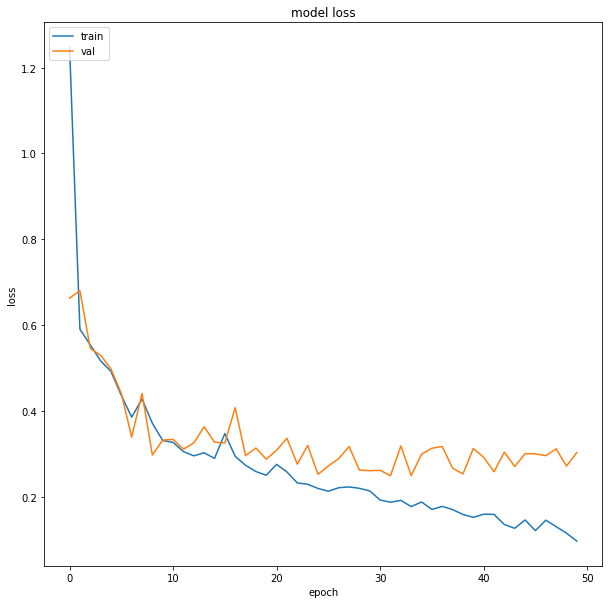

In [13]:
plot_loss(model_hist)

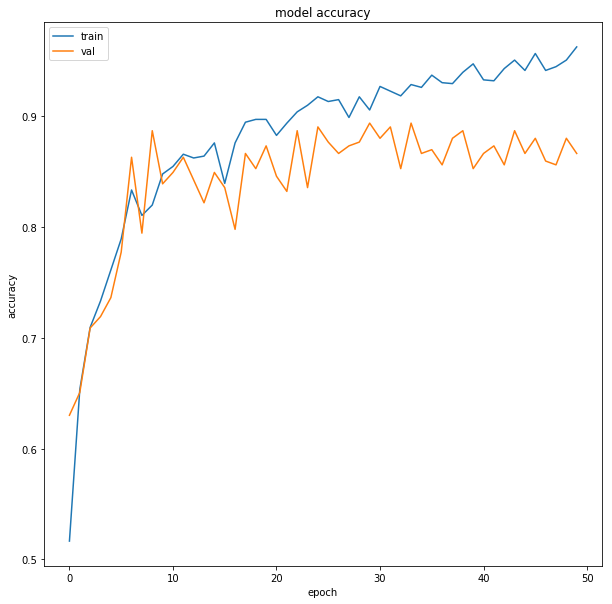

In [14]:
plot_acc(model_hist)

In [ ]:
test_preds = model.predict([X_cnn_test, X_ang_test], batch_size=32)

In [ ]:
sample = 30
get_class(val_preds[sample], val_Y[sample], val_X[sample])

In [ ]:
is_ice = test_preds[:, 1]
ids = TEST_labels

In [ ]:
with open('subv3.csv', 'w') as fp:
    fp.write('id,is_iceberg\n')
    for i in range(len(X_ids)):
        fp.write('{0:},{1:.10f}\n'.format(X_ids[i], test_preds[i,1]))